In [1]:
import pandas as pd
import numpy as np
import matplotlib.style
import matplotlib.pyplot as plt
import yfinance as yf
from pyparsing import empty

pd.options.display.float_format = '{:.4f}'.format
plt.style.use("seaborn-v0_8")
from itertools import product

In [2]:
symbol = "EURUSD=X"
start = "2004-01-01"
end = "2020-01-01"

In [100]:
class StrategyTester():
    def __init__(self, symbol, sma_short, sma_long, start, end, rawdata):
        self.end = end
        self.start = start
        self.sma_long = sma_long
        self.sma_short = sma_short
        self.symbol = symbol
        self.rawdata = rawdata
        self.data = None ##
        self.results = None
        self.perf = None
        self.perf_net = None
        self.outperf = None
        self.ptc = None
        
    def run(self):
        self.data = self.get_data()
        self.results = self.get_results()
        self.perf = self.results['cstrategy'].iloc[-1]
        self.perf_net = self.results['cstrategy_net'].iloc[-1]

    def get_data(self):
        df = self.rawdata
        spread = 1.5 * 0.0001
        halfspread = spread / 2
        self.ptc = halfspread / df.price.mean()
        df['returns'] = np.log(df['price'] / df['price'].shift(1))
        df['sma_short'] = df['price'].rolling(self.sma_short).mean()
        df['sma_long'] = df['price'].rolling(self.sma_long).mean()
        return df
    
    def get_results(self):
        data = self.data.copy().dropna()
        data['position'] = np.where(data['sma_short'] > data['sma_long'], 1, -1)
        data['trades'] = data.position.diff().fillna(0).abs()
        data['strategy'] = data['position'].shift(1) * data['returns']
        data['strategy_net'] = data['position'].shift(1) * data['returns']  - data.trades*self.ptc
        data.dropna(inplace=True)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp) 
        data['cstrategy_net'] = data.strategy_net.cumsum().apply(np.exp)
        
        return data
    
    def plot_results(self):
        title = "{} | SMA short = {} | SMA long = {}".format(self.symbol, self.sma_short, self.sma_long)
        self.results[['creturns', 'cstrategy']].plot(title= title, figsize=(20, 10))


In [103]:
def best_sma_for_instrument(instrument, start, end):
    df = yf.download(instrument, start, end).Close.to_frame()
    df.rename(columns={"Close": "price"}, inplace=True)
    
    # sma_s_range = range(10,80,1)
    # sma_l_range = range(100,252,1)
    sma_s_range = range(3,20,1)
    sma_l_range = range(25,60,1)
    combinations = list(product(sma_s_range, sma_l_range))
    resultsDf = pd.DataFrame(columns=['sma_s', 'sma_l', 'strategy', 'strategy_net'])
    
    for combination in combinations:
        s = StrategyTester(instrument,combination[0], combination[1], start,end, df)
        s.run()
        resultDict = {'sma_s': combination[0], 'sma_l': combination[1], 'strategy': s.perf, 'strategy_net': s.perf_net}
        # print("{}/{} result is {}".format(combination[0], combination[1], s.perf_net))
        resultsDf.loc[len(resultsDf)] = resultDict
    
    return resultsDf

instrument = 'EURUSD=X'
start = '2023-01-01'
end = '2024-01-01'

results = best_sma_for_instrument(instrument, start, end)

# df = yf.download(instrument, start, end).Close.to_frame()
# df.rename(columns={"Close": "price"}, inplace=True)    
# s1 = StrategyTester(instrument,5, 50, start,end, df)
# s1.run()   
# 
# s1.results

results


[*********************100%%**********************]  1 of 1 completed


,sma_s,sma_l,strategy,strategy_net
0,3,25,1.0466,1.0451
1,3,26,1.0472,1.0455
2,3,27,1.0480,1.0462
3,3,28,1.0339,1.0323
4,3,29,1.0184,1.0169
...,...,...,...,...
590,19,55,0.9610,0.9603
591,19,56,0.9549,0.9543
592,19,57,0.9627,0.9621
593,19,58,0.9677,0.9670


[*********************100%%**********************]  1 of 1 completed


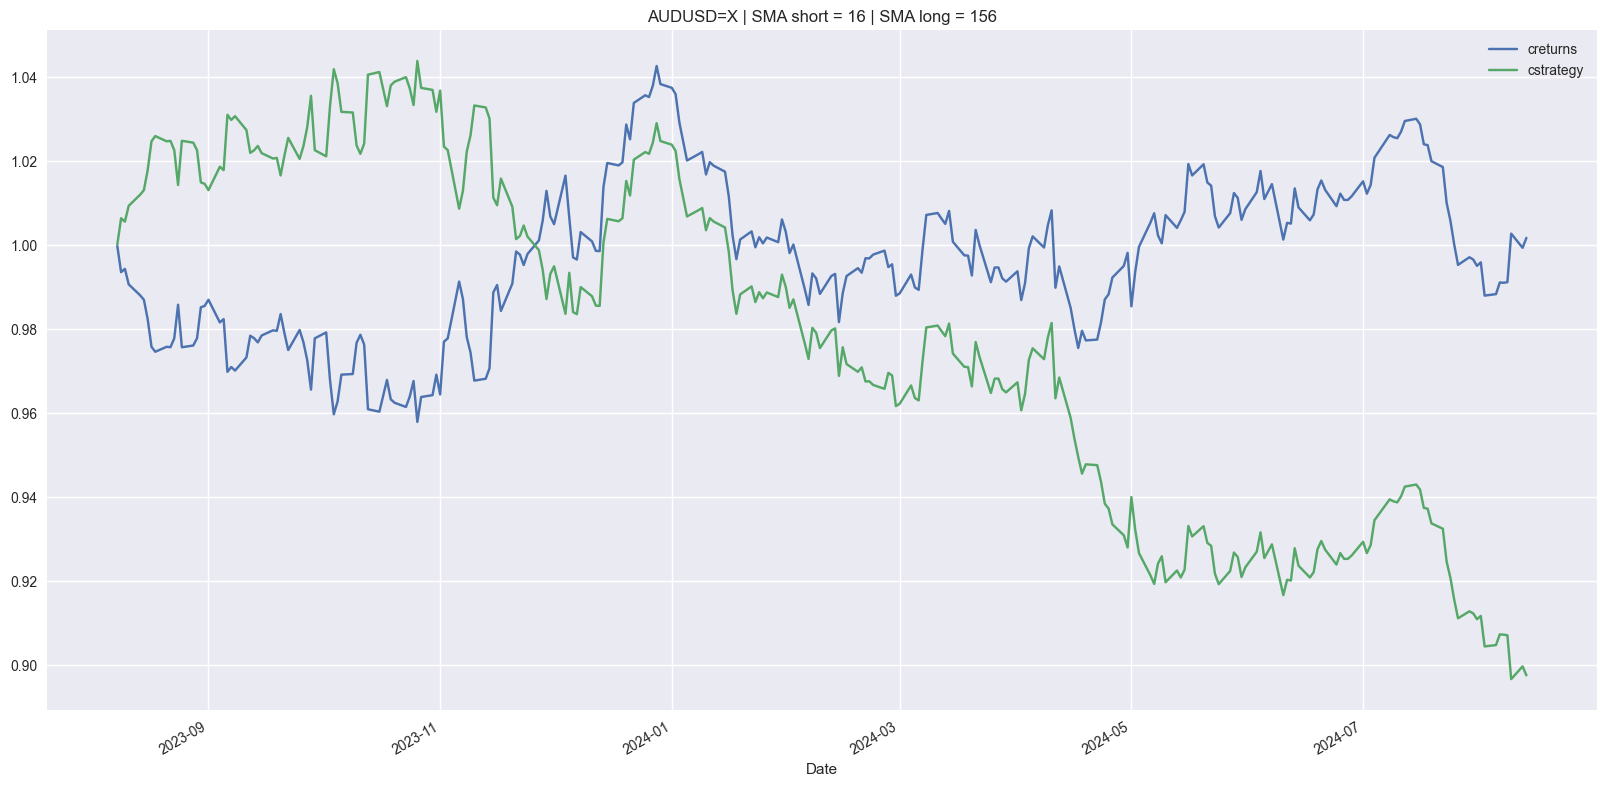

In [57]:
instrument = 'AUDUSD=X'
start = '2023-01-01'
end = '2024-08-14'
df = yf.download(instrument, start, end).Close.to_frame()
df.rename(columns={"Close": "price"}, inplace=True)


audbest = StrategyTester(instrument, 16, 156, start, end, df)
audbest.run()
audbest.plot_results()